In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from astropy.table import Table, join
from astropy import units as u
from edge_pydb import EdgeTable
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

## Plot CO observation parameters, a la Bolatto et al. (2017) Figure 4.

In [2]:
coobs = EdgeTable('edge_coobs_DE.csv')
coobs

Name,coVsys,coDEobstim,coNpt,coDEbmaj,coDEbmin,coRMS_10,coTpk_10,coSNRpeak_10,ImagingDate_10,coRMS_20,coTpk_20,coSNRpeak_20,ImagingDate_20
,km / s,h,,arcsec,arcsec,mK,mK,,,mK,mK,,
str13,float64,float64,int64,float64,float64,float64,int64,float64,str21,float64,int64,float64,str21
ARP220,5340.9,4.0,7,4.48,3.87,41.8,3472,83.03,02/14/16 05:15:10 CST,33.0,3461,104.75,06/09/16 07:03:55 CDT
IC0480,4492.9,3.98,7,4.88,3.93,53.6,810,15.11,02/15/16 16:09:31 CST,42.3,792,18.73,06/08/16 10:40:35 CDT
IC0540,2056.6,3.33,7,6.22,3.64,65.9,375,5.69,02/12/16 17:08:14 CST,51.2,336,6.57,06/08/16 10:49:37 CDT
IC0944,6843.0,4.09,7,5.39,4.17,41.6,317,7.64,02/12/16 17:25:13 CST,32.5,278,8.54,06/08/16 10:59:27 CDT
IC1151,2159.9,2.65,7,5.32,3.78,77.2,382,4.94,02/12/16 17:40:21 CST,60.1,301,5.02,06/08/16 11:07:49 CDT
IC1199,4663.0,3.97,7,4.92,4.3,47.3,351,7.43,02/12/16 17:55:31 CST,37.1,266,7.15,06/08/16 11:16:31 CDT
IC1683,4774.9,4.34,7,4.96,3.79,48.0,785,16.35,02/12/16 18:13:26 CST,37.4,794,21.24,06/08/16 11:27:22 CDT
IC2247,4261.7,4.01,7,4.79,3.85,43.3,438,10.12,02/12/16 18:31:08 CST,34.0,416,12.25,06/08/16 11:37:39 CDT


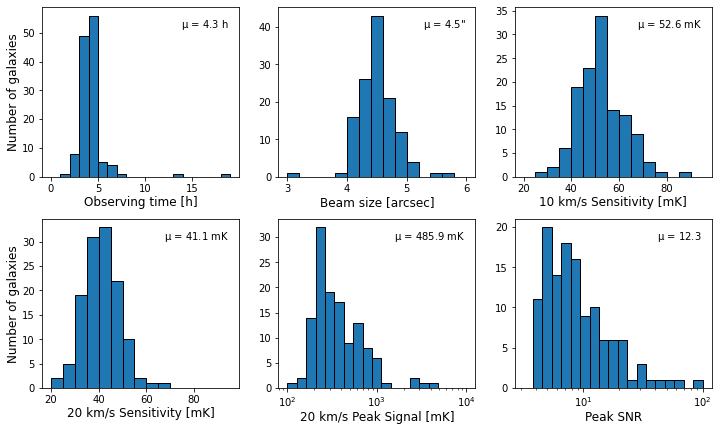

In [3]:
plt.figure(figsize=(12, 7))

ax1=plt.subplot(2,3,1)
plt.hist(coobs['coDEobstim'], bins=np.arange(0, 20, 1), ec='black')
plt.xlabel('Observing time [h]', labelpad=2, fontsize='large')
plt.ylabel('Number of galaxies', labelpad=2, fontsize='large')
ax1.text(0.95,0.88,'$\mu$ = %3.1f h' % np.mean(coobs['coDEobstim']),
    ha='right',transform=ax1.transAxes)

ax2=plt.subplot(2,3,2)
beam=np.sqrt(coobs['coDEbmaj']*coobs['coDEbmin'])
plt.hist(beam, bins=np.arange(3, 6.2, 0.2), ec='black')
plt.xlabel('Beam size [arcsec]', labelpad=2, fontsize='large')
tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.text(0.95,0.88,'$\mu$ = %3.1f"' % np.mean(beam),
    ha='right', transform=ax2.transAxes)

ax3=plt.subplot(2,3,3)
plt.hist(coobs['coRMS_10'], bins=np.arange(20,100,5), ec='black')
plt.xlabel('10 km/s Sensitivity [mK]', labelpad=2, fontsize='large')
ax3.text(0.95,0.88,'$\mu$ = %4.1f mK' % np.mean(coobs['coRMS_10']),
    ha='right', transform=ax3.transAxes)

ax4=plt.subplot(2,3,4)
plt.hist(coobs['coRMS_20'], bins=np.arange(20,100,5), ec='black')
plt.xlabel('20 km/s Sensitivity [mK]', labelpad=2, fontsize='large')
plt.ylabel('Number of galaxies', labelpad=2, fontsize='large')
ax4.text(0.95,0.88,'$\mu$ = %4.1f mK' % np.mean(coobs['coRMS_20']),
    ha='right', transform=ax4.transAxes)

ax5=plt.subplot(2,3,5)
plt.hist(coobs['coTpk_20'], bins=np.logspace(2,4,num=20), ec='black')
plt.xlabel('20 km/s Peak Signal [mK]', labelpad=2, fontsize='large')
ax5.set_xscale("log")
ax5.text(0.95,0.88,'$\mu$ = %4.1f mK' % np.mean(coobs['coTpk_20']),
    ha='right', transform=ax5.transAxes)

ax6=plt.subplot(2,3,6)
plt.hist(coobs['coSNRpeak_20'], bins=np.logspace(0.5,2,num=20), ec='black')
plt.xlabel('Peak SNR', labelpad=2, fontsize='large')
ax6.set_xscale("log")
ax6.text(0.95,0.88,'$\mu$ = %4.1f' % np.mean(coobs['coSNRpeak_20']),
    ha='right', transform=ax6.transAxes)

plt.subplots_adjust(hspace=0.25)
plt.show()

## Derive $S_{CO}$ to $M_{mol}$ conversion.

In [4]:
# Calculate molecular mass for 1 Jy km/s at 1 Mpc.
# These serve as fiducial distance and flux which we will scale later.
sco  = 1 * u.Jy * u.km / u.s
dmpc = (1 * u.Mpc).to(u.pc)
alphaco = 4.3 * u.solMass * u.s / (u.K * u.km * u.pc**2) # Bolatto+13
freq = 115.271204 * u.GHz
kperjy = (1*u.Jy/u.sr).to(u.K, equivalencies=u.brightness_temperature(freq))
molmass = alphaco * kperjy * (sco/u.Jy) * dmpc**2
print(molmass)

10533.068883659096 solMass


## Plot derived CO masses, a la Bolatto et al. (2017) Figure 5.  Need to merge in two additional tables.

In [5]:
# Measured CO fluxes
db = EdgeTable('edge_coflux_natv.csv')
# CALIFA params incl. distance
califa = EdgeTable('edge_califa.csv')
db.join(califa)
db.join(coobs)

In [6]:
db

Name,coRactr_natv,coDectr_natv,coCtrint_natv,coDvhel,coBmaj_natv,coBmin_natv,coBpa_natv,coNomask_natv,coeNomask_natv,coNomaskDv_natv,coDilated_natv,coeDilated_natv,coSmooth_natv,coeSmooth_natv,coSmoothDv_natv,coMask2d_natv,coeMask2d_natv,coSNRmax_natv,coSNR4pix_natv,coSNR5pix_natv,cottBmaj_natv,cottBmin_natv,cottBpa_natv,cottNomask_natv,cotteNomask_natv,cottNomaskDv_natv,cottDilated_natv,cotteDilated_natv,cottSmooth_natv,cotteSmooth_natv,cottSmoothDv_natv,cottMask2d_natv,cotteMask2d_natv,cottSNRmax_natv,cottSNR4pix_natv,cottSNR5pix_natv,caMass,caeMass,caSFR,caeSFR,caOH,caeOH,caAvgas,caeAvgas,caAvstars,caeAvstars,Su,Sg,Sr,Si,caB,caV,caR,caRe,caeRe,caEllipticity,caPA,caR50,caeR50,caR90,caeR90,caOH_O3N2,caZgas,caZstars,caAge,caeAge,caFHa,caFHacorr,caLHacorr,caMstars,caDistMpc,caDistP3d,caFlgWav5,caFlgReg5,caFlgImg5,caFlgWav12,caFlgReg12,caFlgImg12,coVsys,coDEobstim,coNpt,coDEbmaj,coDEbmin,coRMS_10,coTpk_10,coSNRpeak_10,ImagingDate_10,coRMS_20,coTpk_20,coSNRpeak_20,ImagingDate_20
,deg,deg,K km / s,km / s,arcsec,arcsec,deg,Jy km / s,Jy km / s,km / s,Jy km / s,Jy km / s,Jy km / s,Jy km / s,km / s,Jy km / s,Jy km / s,,,,arcsec,arcsec,deg,Jy km / s,Jy km / s,km / s,Jy km / s,Jy km / s,Jy km / s,Jy km / s,km / s,Jy km / s,Jy km / s,,,,dex(solMass),dex(solMass),dex(solMass / yr),dex(solMass / yr),dex,dex,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,arcsec,arcsec,,deg,arcsec,arcsec,arcsec,arcsec,dex,,,dex(Gyr),dex(Gyr),dex(1e-16 erg / (cm2 s)),dex(1e-16 erg / (cm2 s)),dex(erg / s),dex(solMass),Mpc,Mpc,,,,,,,km / s,h,,arcsec,arcsec,mK,mK,,,mK,mK,,
str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,int64,float64,str21,float64,int64,float64,str21
ARP220,233.7383,23.5037,818.519,-16.613,4.480,3.870,71.800,350.730,32.760,1600.000,458.050,2.780,465.400,4.650,900.000,459.270,10.160,104.751,254.000,157.000,4.580,3.920,82.000,-9.000,19.250,1600.000,16.740,0.780,23.340,1.520,780.000,16.040,3.860,6.298,43.000,8.000,10.9099,0.0872049,1.57499,0.180915,nan,nan,5.3402,0.700156,0.401422,1.76844,15.4727663,14.11019518,13.42762456,13.10010398,14.3881919,13.74703758,13.3581267,22.57252232,22.57252232,0.55050123,12.60185186,19.6445391,0.41902297,41.53416839,0.00725311,nan,0.01793838,0.01800146,8.95270263,0.40709788,3.09833195,4.88371559,42.67841756,11.1161373,77.97227561,77.56961742547331,0,0,0,0,0,0,5340.9,4.0,7,4.48,3.87,41.8,3472,83.03,02/14/16 05:15:10 CST,33.0,3461,104.75,06/09/16 07:03:55 CDT
IC0480,118.8467,26.7411,46.882,9.209,4.880,3.930,42.800,37.160,32.560,860.000,79.490,2.070,82.230,3.760,420.000,75.490,8.780,18.732,235.000,184.000,4.940,4.060,46.000,-9.040,16.160,860.000,3.490,0.420,4.730,0.760,220.000,5.510,2.160,5.470,48.000,3.000,10.2656,0.134175,0.113128,0.10015,8.48813,0.0458044,1.28283,0.0682296,0.401506,1.33692,16.11139949,15.0510197,14.47673959,14.17375345,15.26121259,14.76638769,14.41251353,20.20523629,20.20523629,0.98072158,-12.39856666,20.62375599,0.46026049,42.91970841,0.16740285,8.48941,0.01528139,0.01527649,8.75405618,0.40396314,3.11992931,3.26047552,40.94567316,10.39968968,66.2859101,65.06141916401238,1,0,0,0,1,0,4492.9,3.98,7,4.88,3.93,53.6,810,15.11,02/15/16 16:09:31 CST,42.3,792,18.73,06/08/16 10:40:35 CDT
IC0540,142.5429,7.9028,40.340,9.316,6.220,3.630,31.000,-19.500,42.370,860.000,19.930,1.600,27.900,3.260,280.000,40.290,9.010,6.571,51.000,14.000,6.360,3.790,30.900,11.390,18.470,860.000,nan,nan,nan,nan,nan,nan,nan,4.877,21.0

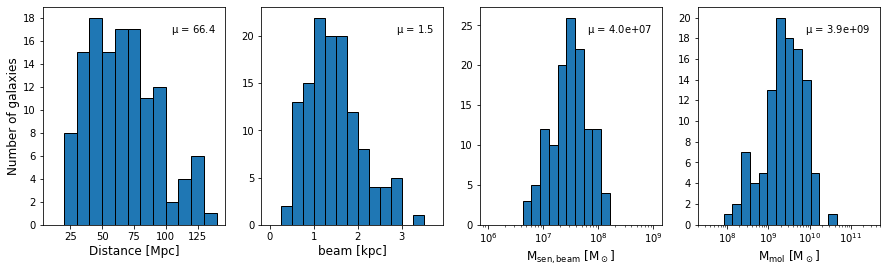

In [7]:
fig=plt.figure(figsize=(15, 4))

# Histogram of distance
ax1=plt.subplot(1,4,1)
plt.hist(db['caDistMpc'],bins=np.arange(10, 150, 10), ec='black')
plt.xlabel('Distance [Mpc]', labelpad=3, fontsize='large')
plt.ylabel('Number of galaxies', labelpad=3, fontsize='large')
tick_spacing = 2
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.text(0.95,0.88,'$\mu$ = %3.1f' % np.mean(db['caDistMpc']),
    ha='right', transform=ax1.transAxes)

# Histogram of beam physical size
ax2=plt.subplot(1,4,2)
beam = (np.sqrt(db['coBmaj_natv']*db['coBmin_natv'])).to(u.rad)
bmkpc = beam.value*db['caDistMpc']*1000.
plt.hist(bmkpc,bins=np.arange(0, 4, 0.25), ec='black')
plt.xlabel('beam [kpc]', labelpad=3, fontsize='large')
ax2.text(0.95,0.88,'$\mu$ = %3.1f' % np.mean(bmkpc),
    ha='right', transform=ax2.transAxes)

# Histogram of beam mass sensitivity
ax3=plt.subplot(1,4,3)
# Convert mK to Jy/bm
omega_B = np.pi/(4*np.log(2)) * beam**2
conv = (u.Jy/omega_B).to(u.mK, equivalencies=u.brightness_temperature(freq))
mkperjy = conv.value
# Multiply 10 km/s noise by sqrt(3) to get sensitivity to a 30 km/s line
# Multiply by 4 to get 4-sigma sensitivity
msens = 4*molmass*(db['caDistMpc']**2)*(db['coRMS_10']/mkperjy)*10.*np.sqrt(3)
plt.hist(msens.value,bins=np.logspace(6, 9, num=20), ec='black')
plt.xlabel('$M_{sen,beam}$ [$M_\odot$]', labelpad=3, fontsize='large')
ax3.set_xscale("log")
ax3.text(0.95,0.88,'$\mu$ = %4.1e' % np.mean(msens.value),
    ha='right', transform=ax3.transAxes)

# Histogram of molecular gas mass
ax4=plt.subplot(1,4,4)
mgas = molmass*db['caDistMpc']**2*db['coSmooth_natv']
mgas = mgas[~np.isnan(mgas)]
plt.hist(mgas.value,bins=np.logspace(7.5, 11.5, num=20), ec='black')
plt.xlabel('$M_{mol}$ [$M_\odot$]', labelpad=3, fontsize='large')
ax4.set_xscale("log")
ax4.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax4.text(0.95,0.88,'$\mu$ = %4.1e' % np.mean(mgas.value),
    ha='right', transform=ax4.transAxes)

plt.show()

## Make scatterplots related to star-forming main sequence

In [8]:
print(califa.colnames)

['Name', 'caMass', 'caeMass', 'caSFR', 'caeSFR', 'caOH', 'caeOH', 'caAvgas', 'caeAvgas', 'caAvstars', 'caeAvstars', 'Su', 'Sg', 'Sr', 'Si', 'caB', 'caV', 'caR', 'caRe', 'caeRe', 'caEllipticity', 'caPA', 'caR50', 'caeR50', 'caR90', 'caeR90', 'caOH_O3N2', 'caZgas', 'caZstars', 'caAge', 'caeAge', 'caFHa', 'caFHacorr', 'caLHacorr', 'caMstars', 'caDistMpc', 'caDistP3d', 'caFlgWav5', 'caFlgReg5', 'caFlgImg5', 'caFlgWav12', 'caFlgReg12', 'caFlgImg12']


dex(solMass) dex(solMass / yr)


Text(0, 0.5, 'log(SFR [$M_\\odot$ yr$^{-1}$])')

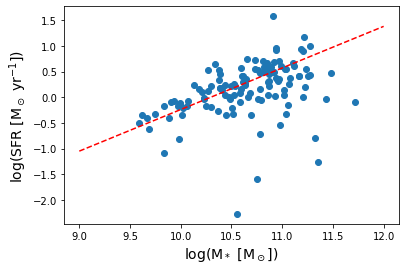

In [9]:
print(db['caMass'].unit,db['caSFR'].unit)
valid_ssfr = (~np.isnan(db['caMass'])) & (~np.isnan(db['caSFR']))
plt.scatter(db['caMass'][valid_ssfr],db['caSFR'][valid_ssfr])
x_ms = np.linspace(9,12,num=50)
y_ms = 0.81*x_ms-8.34
plt.plot(x_ms,y_ms,'r--')
plt.xlabel('log($M_*$ [$M_\odot$])', fontsize=14)
plt.ylabel('log(SFR [$M_\odot$ yr$^{-1}$])', fontsize=14)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'log($t_{dep}$ [yr])')

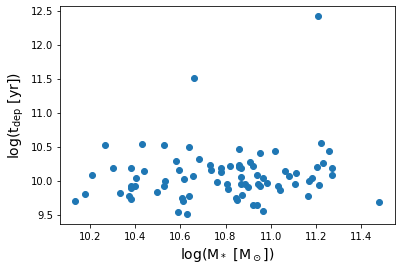

In [10]:
gasmass = molmass*db['coSmooth_natv']*db['caDistMpc']**2
det  = np.where(db['coSmooth_natv']/db['coeSmooth_natv']>=4)[0]
ndet = np.where(db['coSmooth_natv']/db['coeSmooth_natv']<4)[0]
tgaslg = np.log10(gasmass.value/db['caSFR'])
plt.scatter(db['caMass'][det],tgaslg[det])
plt.scatter(db['caMass'][ndet],tgaslg[ndet],color='red')
uplims = np.zeros(db['caMass'][ndet].shape)
uplims[:] = True
plt.errorbar(db['caMass'][ndet],tgaslg[ndet], uplims=uplims, 
             yerr=0.2, ls='none', color='red')
plt.xlabel('log($M_*$ [$M_\odot$])', fontsize=14)
plt.ylabel('log($t_{dep}$ [yr])', fontsize=14)

Text(0.5, 0, 'log($M(H_2)$ [$M_\\odot$])')

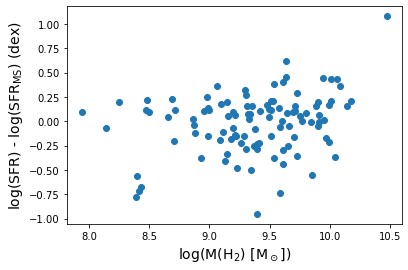

In [11]:
delsfr = db['caSFR'] - (0.81*db['caMass']-8.34)
valid_mgas = (~np.isnan(db['caMass'])) & (~np.isnan(db['caSFR'])) & (~np.isnan(db['coSmooth_natv']))
mgas = np.log10(1.05e4*db['caDistMpc']**2*db['coSmooth_natv'])
plt.scatter(mgas[valid_mgas], delsfr[valid_mgas])
plt.ylabel(r'log(SFR) - log(SFR$_{\rm MS}$) (dex)', fontsize=14)
plt.xlabel('log($M(H_2)$ [$M_\odot$])', fontsize=14)

Text(0.5, 0, 'log($M(H_2)/M_*$)')

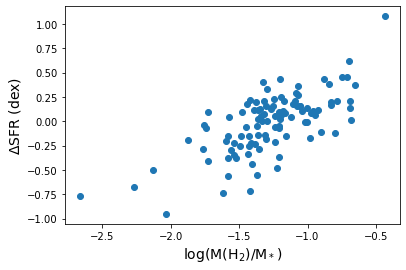

In [12]:
fgas = mgas - db['caMass']
plt.scatter(fgas[valid_mgas], delsfr[valid_mgas])
plt.ylabel('$\Delta$SFR (dex)', fontsize=14)
plt.xlabel('log($M(H_2)/M_*$)', fontsize=14)